Read Data

In [3]:
import pandas as pd
df = pd.read_csv('taskA.csv', header=None, nrows = 835)

Identify relevant ids

In [4]:
ids = [('voltage', 0), ('current', 0), ('frontLeft', 0), ('frontRight', 0), ('backLeft', 0), ('backRight', 0)]
idNames = ['ams.pack.voltage', 'ams.pack.current', 'pcm.wheelSpeeds.frontLeft', 'pcm.wheelSpeeds.frontRight',
        'pcm.wheelSpeeds.backLeft', 'pcm.wheelSpeeds.backRight']
relevant = [(row[row.index('(')+1:row.index(')')], int(row[-4:])) for row in df[0] if True in [name in row for name in idNames]]
relevantIds = [int(_[1]) for _ in relevant]
#print(relevant, relevantIds)

Pull out relevant values/reformatting

In [5]:
data = pd.read_csv('taskA.csv', names = ['timestamp', 'id', 'val'], skiprows = lambda x: x < 835)

In [6]:
ids = data.pop('id')
data.insert(0, 'id',ids)
data.head()

,id,timestamp,val
0,8468,125000,4.13725
1,8469,125000,4.13785
2,8470,125000,4.12840
3,8471,125000,4.13330
4,8474,125000,4.08960


In [7]:
# new = data[data['id'].isin([8753, 8754])]
# new.head()
# print(len(new))

Create dataframes for current and voltage

In [8]:
current = data[data['id'].isin([8753])]
current.reset_index(drop=True, inplace=True)
current.head()
#current.plot(x = 'timestamp', y = 'val')

,id,timestamp,val
0,8753,125027,0.507642
1,8753,125028,0.877678
2,8753,125029,0.810370
3,8753,125031,0.793709
4,8753,125032,0.911335


In [9]:
voltage = data[data['id'].isin([8754])]
voltage.reset_index(drop=True, inplace=True)
voltage.head()
#voltage.plot(x = 'timestamp', y = 'val')

,id,timestamp,val
0,8754,125027,1.831502
1,8754,125029,0.000000
2,8754,125030,0.732601
3,8754,125031,2.197802
4,8754,125032,0.366300


Combine dfs for current/voltage and calculate power

<Axes: xlabel='timestamp'>

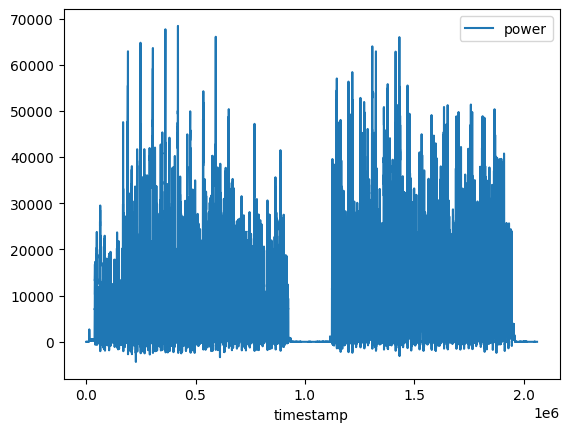

In [10]:
powerDf = pd.DataFrame((voltage['timestamp']+current['timestamp'])/2-125000)
power = current['val']*voltage['val']
powerDf.insert(1, 'power', power)
powerDf.head()
powerDf.plot(y='power', x='timestamp')

In [11]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\dpnim\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Numerically integrate power and convert to kwh

In [12]:
from scipy import integrate

powerInt = integrate.trapezoid(y=powerDf['power'], x=powerDf['timestamp'])
print(powerInt)
#print(powerDf['timestamp'].iloc[-1], powerDf['timestamp'][0])

print(powerInt/1000/3600/1000)

17459478951.9891
4.849855264441418


Find min/max/average speed

In [14]:
#8385-8387, 8393
backLeftDf = data[data['id']==8385]
backRightDf = data[data['id']==8386]
frontLeftDf = data[data['id']==8387]
frontRightDf = data[data['id']==8393]
backLeftDf.reset_index(drop=True, inplace=True)
backRightDf.reset_index(drop=True, inplace=True)
frontLeftDf.reset_index(drop=True, inplace=True)
frontRightDf.reset_index(drop=True, inplace=True)


mphDf = pd.DataFrame({'timestamp':(backLeftDf['timestamp']+backRightDf['timestamp']+frontRightDf['timestamp']+frontLeftDf['timestamp'])/4,
                      'val': (backLeftDf['val']+backRightDf['val']+frontRightDf['val']+frontLeftDf['val'])/4})
#mphDf.head()
#print(backLeftDf['timestamp']+backRightDf['timestamp'])
#speed = (backLeftDf['timestamp']+backRightDf['timestamp']+frontRightDf['timestamp']+frontLeftDf['timestamp'])/4
#print((len(mphDf)))
#mphDf.plot(x='timestamp', y='val')
print(mphDf.max())
print(mphDf.min())
mphInt = integrate.trapezoid(y=mphDf['val'], x=mphDf['timestamp'])
print(mphInt/(float(mphDf['timestamp'].iloc[-1]) - float(mphDf['timestamp'][0])))

timestamp    2.186173e+06
val          4.968134e+01
dtype: float64
timestamp    125094.0
val               0.0
dtype: float64
23.963771430730564
